# Project on Kaggle data: Airbnb prices in European cities 
<br>This Jupyter Notebook contains information and data analysis about different Airbnb housing prices on weekdays and weekends in 10 European cities: Amsterdam, Barcelona, Berlin, Budapest, Lisbon, London, Paris and Rome.

First, we are loading all the CSV files into Pandas DataFrames.

In [54]:
import pandas as pd

amsterdam_weekdays = pd.read_csv('amsterdam_weekdays.csv')
amsterdam_weekends = pd.read_csv('amsterdam_weekends.csv')

athens_weekdays = pd.read_csv('athens_weekdays.csv')
athens_weekends = pd.read_csv('athens_weekends.csv')

barcelona_weekdays = pd.read_csv('barcelona_weekdays.csv')
barcelona_weekends = pd.read_csv('barcelona_weekends.csv')

berlin_weekdays = pd.read_csv('berlin_weekdays.csv')
berlin_weekends = pd.read_csv('berlin_weekends.csv')

budapest_weekdays = pd.read_csv('budapest_weekdays.csv')
budapest_weekends = pd.read_csv('budapest_weekends.csv')

lisbon_weekdays = pd.read_csv('lisbon_weekdays.csv')
lisbon_weekends = pd.read_csv('lisbon_weekends.csv')

london_weekdays = pd.read_csv('london_weekdays.csv')
london_weekends = pd.read_csv('london_weekends.csv')

paris_weekdays = pd.read_csv('paris_weekdays.csv')
paris_weekends = pd.read_csv('paris_weekends.csv')

rome_weekdays = pd.read_csv('rome_weekdays.csv')
rome_weekends = pd.read_csv('rome_weekends.csv')

vienna_weekdays = pd.read_csv('vienna_weekdays.csv')
vienna_weekends = pd.read_csv('vienna_weekends.csv')

To give a quick overview of what's the data going to be like, we are displaying the first few rows of Amsterdam's data on weekdays. Every other CSV file consists of the same possible features and values.

In [55]:
amsterdam_weekdays.head()

,Unnamed: 0,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat
0,0,194.033698,Private room,False,True,2.0,False,1,0,10.0,93.0,1,5.022964,2.539380,78.690379,4.166708,98.253896,6.846473,4.90569,52.41772
1,1,344.245776,Private room,False,True,4.0,False,0,0,8.0,85.0,1,0.488389,0.239404,631.176378,33.421209,837.280757,58.342928,4.90005,52.37432
2,2,264.101422,Private room,False,True,2.0,False,0,1,9.0,87.0,1,5.748312,3.651621,75.275877,3.985908,95.386955,6.646700,4.97512,52.36103
3,3,433.529398,Private room,False,True,4.0,False,0,1,9.0,90.0,2,0.384862,0.439876,493.272534,26.119108,875.033098,60.973565,4.89417,52.37663
4,4,485.552926,Private room,False,True,2.0,True,0,0,10.0,98.0,1,0.544738,0.318693,552.830324,29.272733,815.305740,56.811677,4.90051,52.37508


In [56]:
amsterdam_weekdays.shape

(1103, 20)

As there is neither explanation nor deffintion for the next features - 
<br>attr_index	<br>attr_index_norm	<br>rest_index	<br>rest_index_norm
<br> - we are not going to use them. In addition, there is an unnamed index column at the beginning which we don't use either. So we are removing these columns from each dataset.

In [57]:
datasets = [
    amsterdam_weekdays, amsterdam_weekends,
    athens_weekdays, athens_weekends,
    barcelona_weekdays, barcelona_weekends,
    berlin_weekdays, berlin_weekends,
    budapest_weekdays, budapest_weekends,
    lisbon_weekdays, lisbon_weekends,
    london_weekdays, london_weekends,
    paris_weekdays, paris_weekends,
    rome_weekdays, rome_weekends,
    vienna_weekdays, vienna_weekends
]

columns_to_remove = ['attr_index', 'attr_index_norm', 'rest_index', 'rest_index_norm']

for dataset in datasets:
    # Remove specified columns
    dataset.drop(columns=columns_to_remove, inplace=True)
    # Remove the first index column
    dataset.drop(dataset.columns[0], axis=1, inplace=True)


In [58]:
amsterdam_weekdays.head()

,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,lng,lat
0,194.033698,Private room,False,True,2.0,False,1,0,10.0,93.0,1,5.022964,2.539380,4.90569,52.41772
1,344.245776,Private room,False,True,4.0,False,0,0,8.0,85.0,1,0.488389,0.239404,4.90005,52.37432
2,264.101422,Private room,False,True,2.0,False,0,1,9.0,87.0,1,5.748312,3.651621,4.97512,52.36103
3,433.529398,Private room,False,True,4.0,False,0,1,9.0,90.0,2,0.384862,0.439876,4.89417,52.37663
4,485.552926,Private room,False,True,2.0,True,0,0,10.0,98.0,1,0.544738,0.318693,4.90051,52.37508


In [60]:
datasets = {
    'amsterdam_weekdays': amsterdam_weekdays, 
    'amsterdam_weekends': amsterdam_weekends,
    'athens_weekdays': athens_weekdays, 
    'athens_weekends': athens_weekends,
    'barcelona_weekdays': barcelona_weekdays, 
    'barcelona_weekends': barcelona_weekends,
    'berlin_weekdays': berlin_weekdays, 
    'berlin_weekends': berlin_weekends,
    'budapest_weekdays': budapest_weekdays, 
    'budapest_weekends': budapest_weekends,
    'lisbon_weekdays': lisbon_weekdays, 
    'lisbon_weekends': lisbon_weekends,
    'london_weekdays': london_weekdays, 
    'london_weekends': london_weekends,
    'paris_weekdays': paris_weekdays, 
    'paris_weekends': paris_weekends,
    'rome_weekdays': rome_weekdays, 
    'rome_weekends': rome_weekends,
    'vienna_weekdays': vienna_weekdays, 
    'vienna_weekends': vienna_weekends
}

for name, dataset in datasets.items():
    print(f'{name} shape = {dataset.shape}')


amsterdam_weekdays shape = (1103, 15)
amsterdam_weekends shape = (977, 15)
athens_weekdays shape = (2653, 15)
athens_weekends shape = (2627, 15)
barcelona_weekdays shape = (1555, 15)
barcelona_weekends shape = (1278, 15)
berlin_weekdays shape = (1284, 15)
berlin_weekends shape = (1200, 15)
budapest_weekdays shape = (2074, 15)
budapest_weekends shape = (1948, 15)
lisbon_weekdays shape = (2857, 15)
lisbon_weekends shape = (2906, 15)
london_weekdays shape = (4614, 15)
london_weekends shape = (5379, 15)
paris_weekdays shape = (3130, 15)
paris_weekends shape = (3558, 15)
rome_weekdays shape = (4492, 15)
rome_weekends shape = (4535, 15)
vienna_weekdays shape = (1738, 15)
vienna_weekends shape = (1799, 15)


<br>Our first goal is to indentify the overall prices in the 10 cities and we want to find out cities with highest and lowest housing prices.
<br>

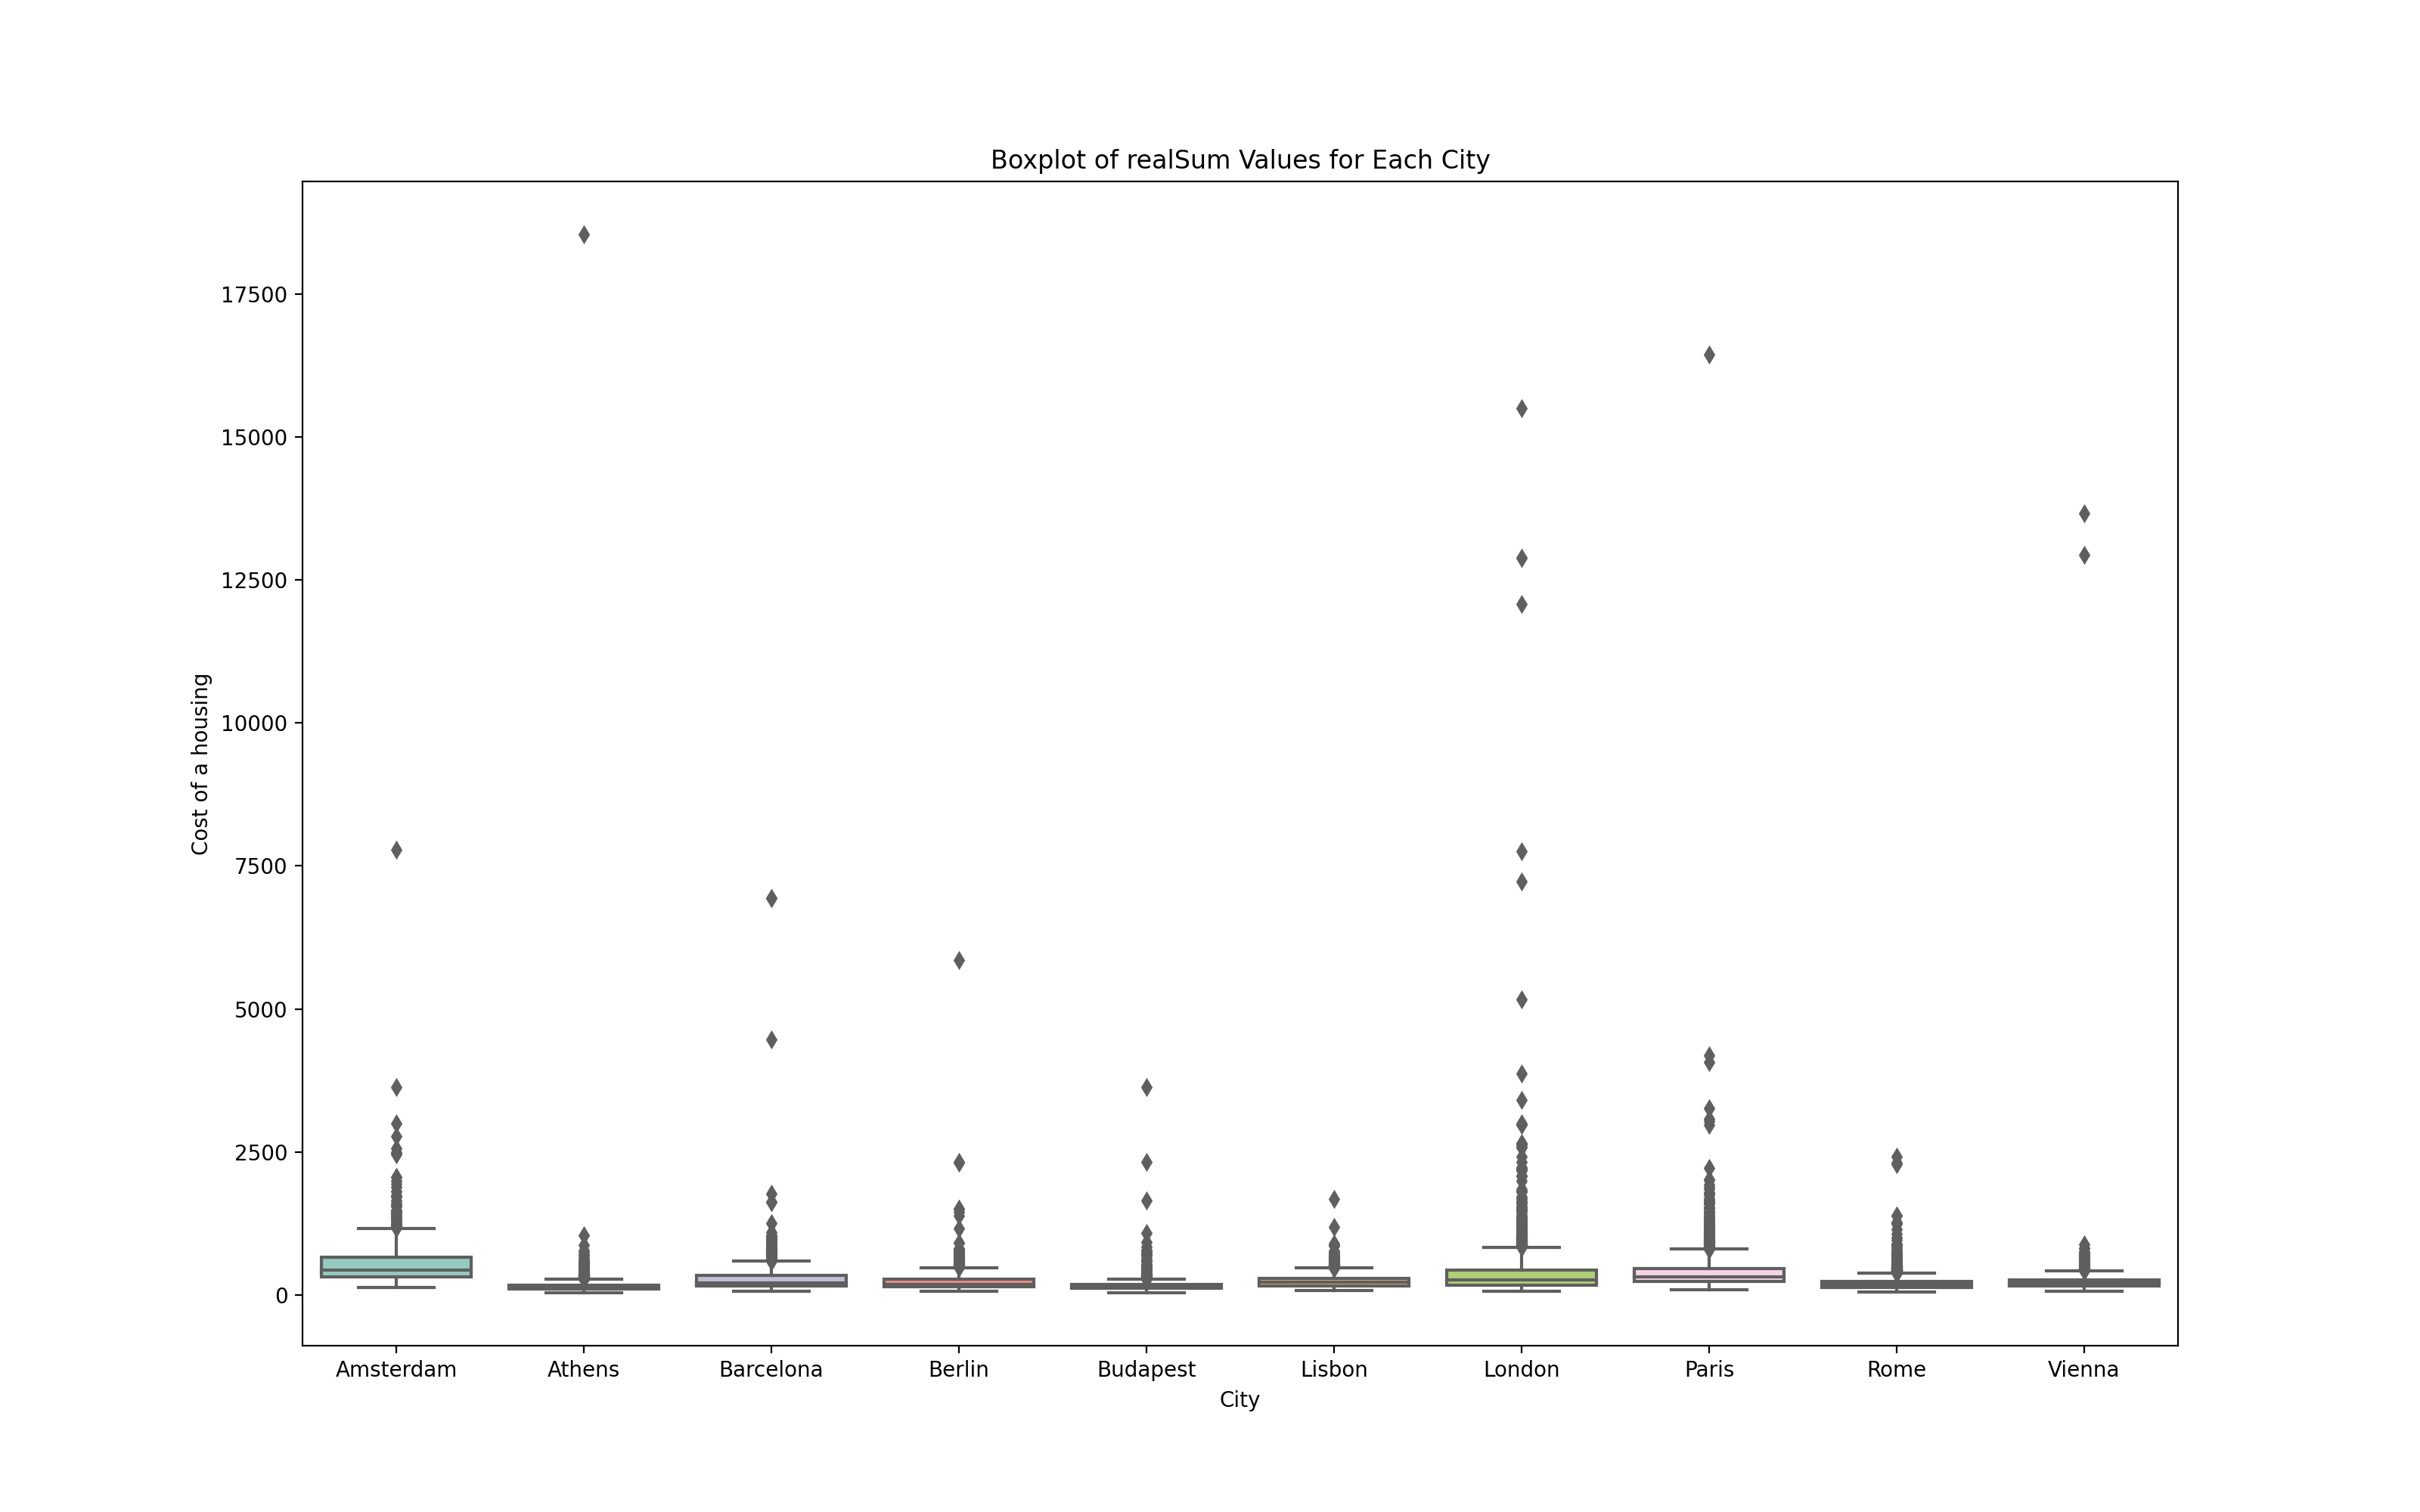

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

# Combine all datasets into one DataFrame
all_data = pd.concat([
    amsterdam_weekdays,
    athens_weekdays,
    barcelona_weekdays,
    berlin_weekdays,
    budapest_weekdays,
    lisbon_weekdays,
    london_weekdays,
    paris_weekdays,
    rome_weekdays,
    vienna_weekdays
], keys=['Amsterdam', 'Athens', 'Barcelona', 'Berlin', 'Budapest', 'Lisbon', 'London', 'Paris', 'Rome', 'Vienna'])

# Increase the figure size
plt.figure(figsize=(16, 10))

# Boxplot using Seaborn
sns.boxplot(x='level_0', y='realSum', data=all_data.reset_index(), palette='Set3')

plt.title('Boxplot of realSum Values for Each City')
plt.xlabel('City')
plt.ylabel('Cost of a housing')
plt.show()

Although the boxplot for all the cities appears quite small, it reveals some initial insights when zoomed in. Athens, Budapest, and Rome have the lowest minimum scores, suggesting that these cities have lower accommodation prices compared to others in the dataset. Conversely, the cities with the maximum scores - Athens, Amsterdam, Paris, and London - are clearly visible, indicating higher prices for accommodations.

But we are going to take a closer and more precise look on the cities.

To make analysis easier though, we are combining all the datasets to one big dataset. Accordingly, we are adding time and city column to represent the city and whether it's weekend or weekday.

In [70]:
# First, create a list of your datasets and their names
datasets = [
    ('amsterdam', 'weekday', amsterdam_weekdays),
    ('amsterdam', 'weekend', amsterdam_weekends),
    ('athens', 'weekday', athens_weekdays),
    ('athens', 'weekend', athens_weekends),
    ('barcelona', 'weekday', barcelona_weekdays),
    ('barcelona', 'weekend', barcelona_weekends),
    ('berlin', 'weekday', berlin_weekdays),
    ('berlin', 'weekend', berlin_weekends),
    ('budapest', 'weekday', budapest_weekdays),
    ('budapest', 'weekend', budapest_weekends),
    ('lisbon', 'weekday', lisbon_weekdays),
    ('lisbon', 'weekend', lisbon_weekends),
    ('london', 'weekday', london_weekdays),
    ('london', 'weekend', london_weekends),
    ('paris', 'weekday', paris_weekdays),
    ('paris', 'weekend', paris_weekends),
    ('rome', 'weekday', rome_weekdays),
    ('rome', 'weekend', rome_weekends),
    ('vienna', 'weekday', vienna_weekdays),
    ('vienna', 'weekend', vienna_weekends)
]

# Then, add the 'city' and 'time' columns to each dataset
for city, time, dataset in datasets:
    dataset['city'] = city
    dataset['time'] = time

# Finally, concatenate all the datasets into one
all_cities = pd.concat([dataset for city, time, dataset in datasets], ignore_index=True)


In [71]:
all_cities.shape

(51707, 17)

In [82]:
all_cities.isnull().sum()

realSum                       0
room_type                     0
room_shared                   0
room_private                  0
person_capacity               0
host_is_superhost             0
multi                         0
biz                           0
cleanliness_rating            0
guest_satisfaction_overall    0
bedrooms                      0
dist                          0
metro_dist                    0
lng                           0
lat                           0
city                          0
time                          0
dtype: int64

In [72]:
all_cities['realSum'].describe()

count    51707.000000
mean       279.879591
std        327.948386
min         34.779339
25%        148.752174
50%        211.343089
75%        319.694287
max      18545.450285
Name: realSum, dtype: float64

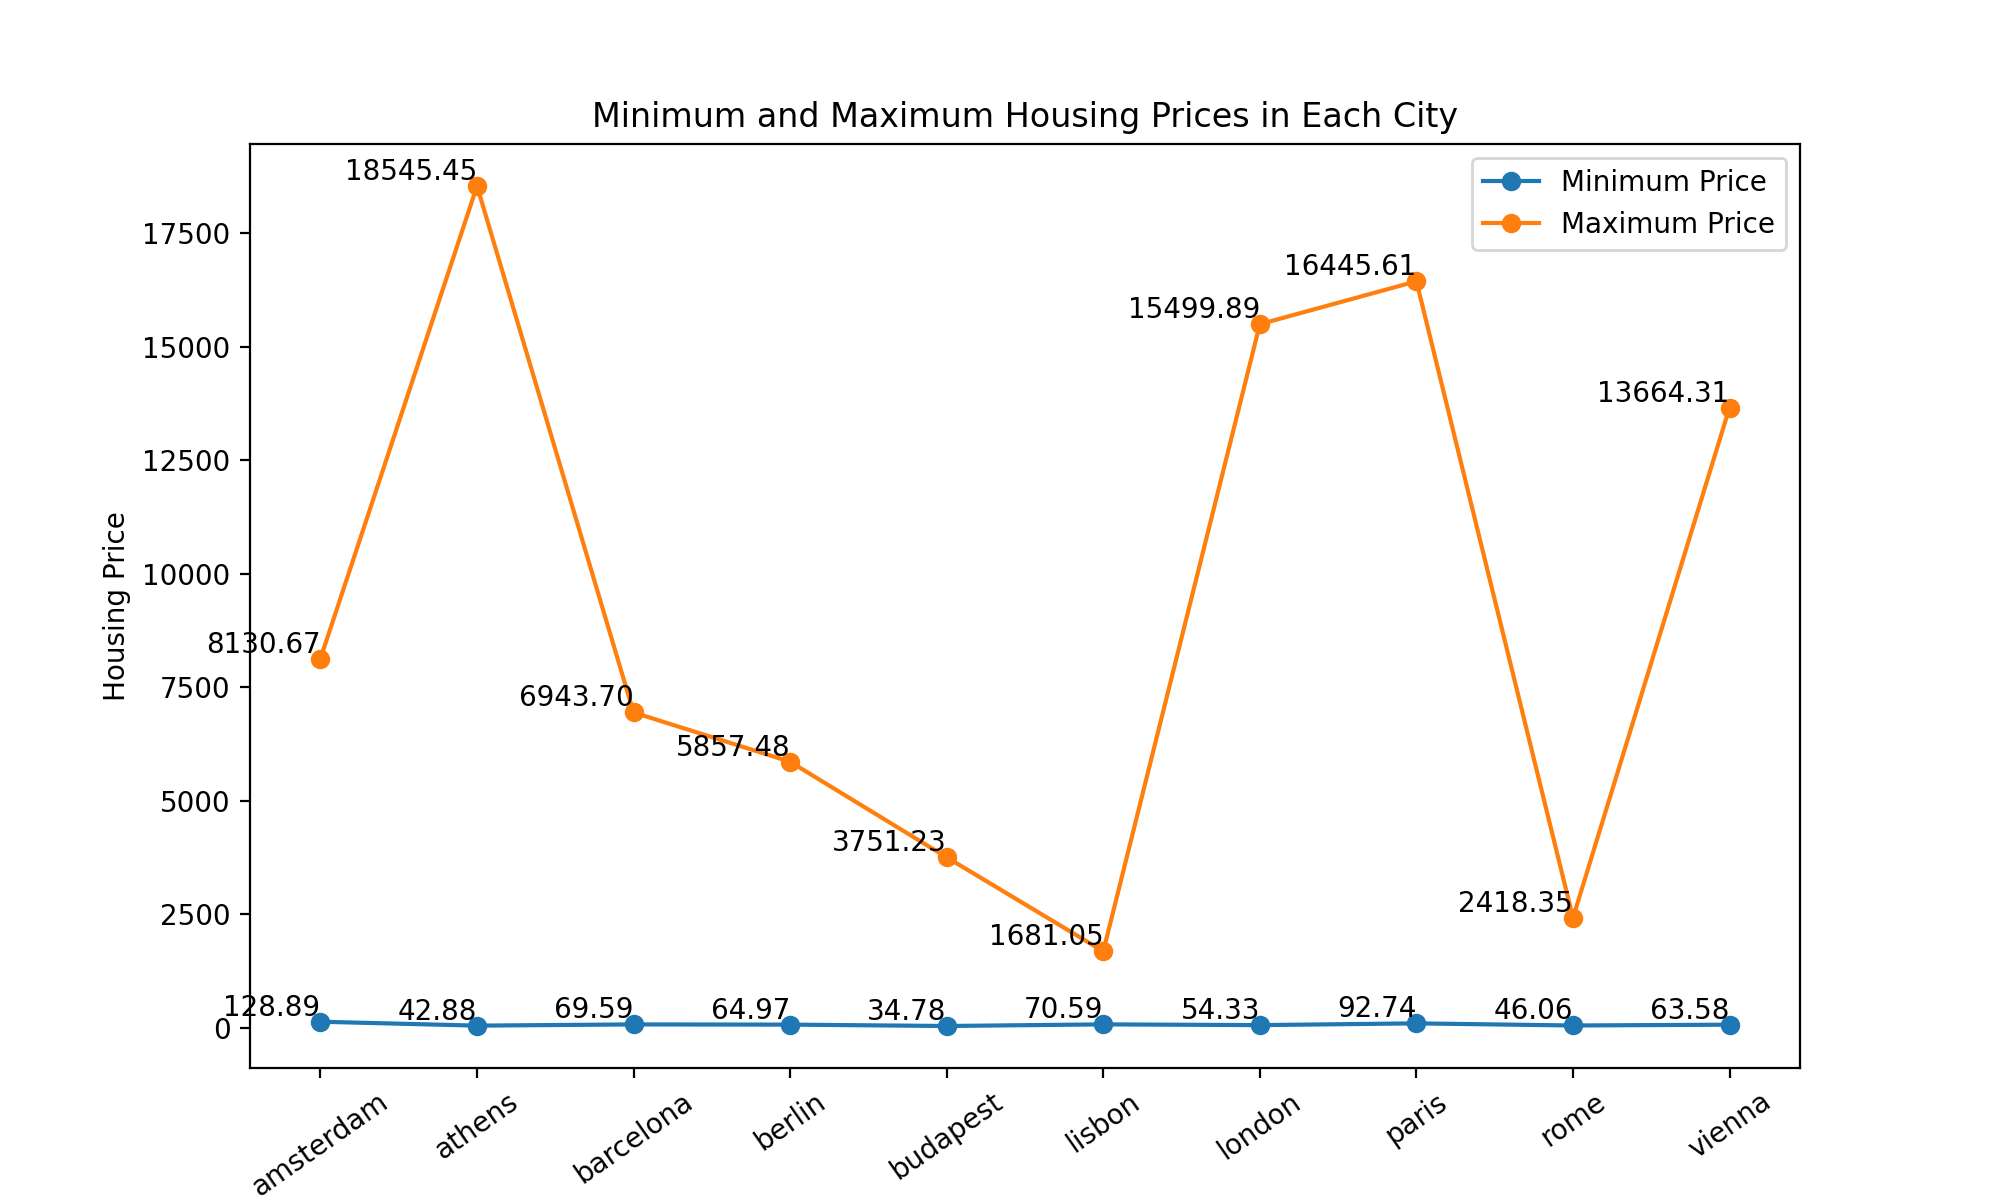

In [80]:
import matplotlib.pyplot as plt

# Calculate the minimum and maximum housing prices in each city
city_min_max = all_cities.groupby('city')['realSum'].agg(['min', 'max'])

# Create a new figure and set its size
plt.figure(figsize=(10, 6))

# Plot the minimum and maximum prices for each city
plt.plot(city_min_max['min'], marker='o', label='Minimum Price')
plt.plot(city_min_max['max'], marker='o', label='Maximum Price')

# Add labels to the points
for i, price in enumerate(city_min_max['min']):
    plt.text(i, price, f'{price:.2f}', verticalalignment='bottom', horizontalalignment='right')
for i, price in enumerate(city_min_max['max']):
    plt.text(i, price, f'{price:.2f}', verticalalignment='bottom', horizontalalignment='right')

# Add labels and title
plt.xlabel('City')
plt.ylabel('Housing Price')
plt.title('Minimum and Maximum Housing Prices in Each City')

# Add a legend
plt.legend()

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=35)

# Show the plot
plt.show()


Here we can clearly see that Budapest has the lowest accommodation price available and Athens the highest price.

Second goal of our project is to identify the city with the biggest price difference, depending on whether it is a weekday or weekend.

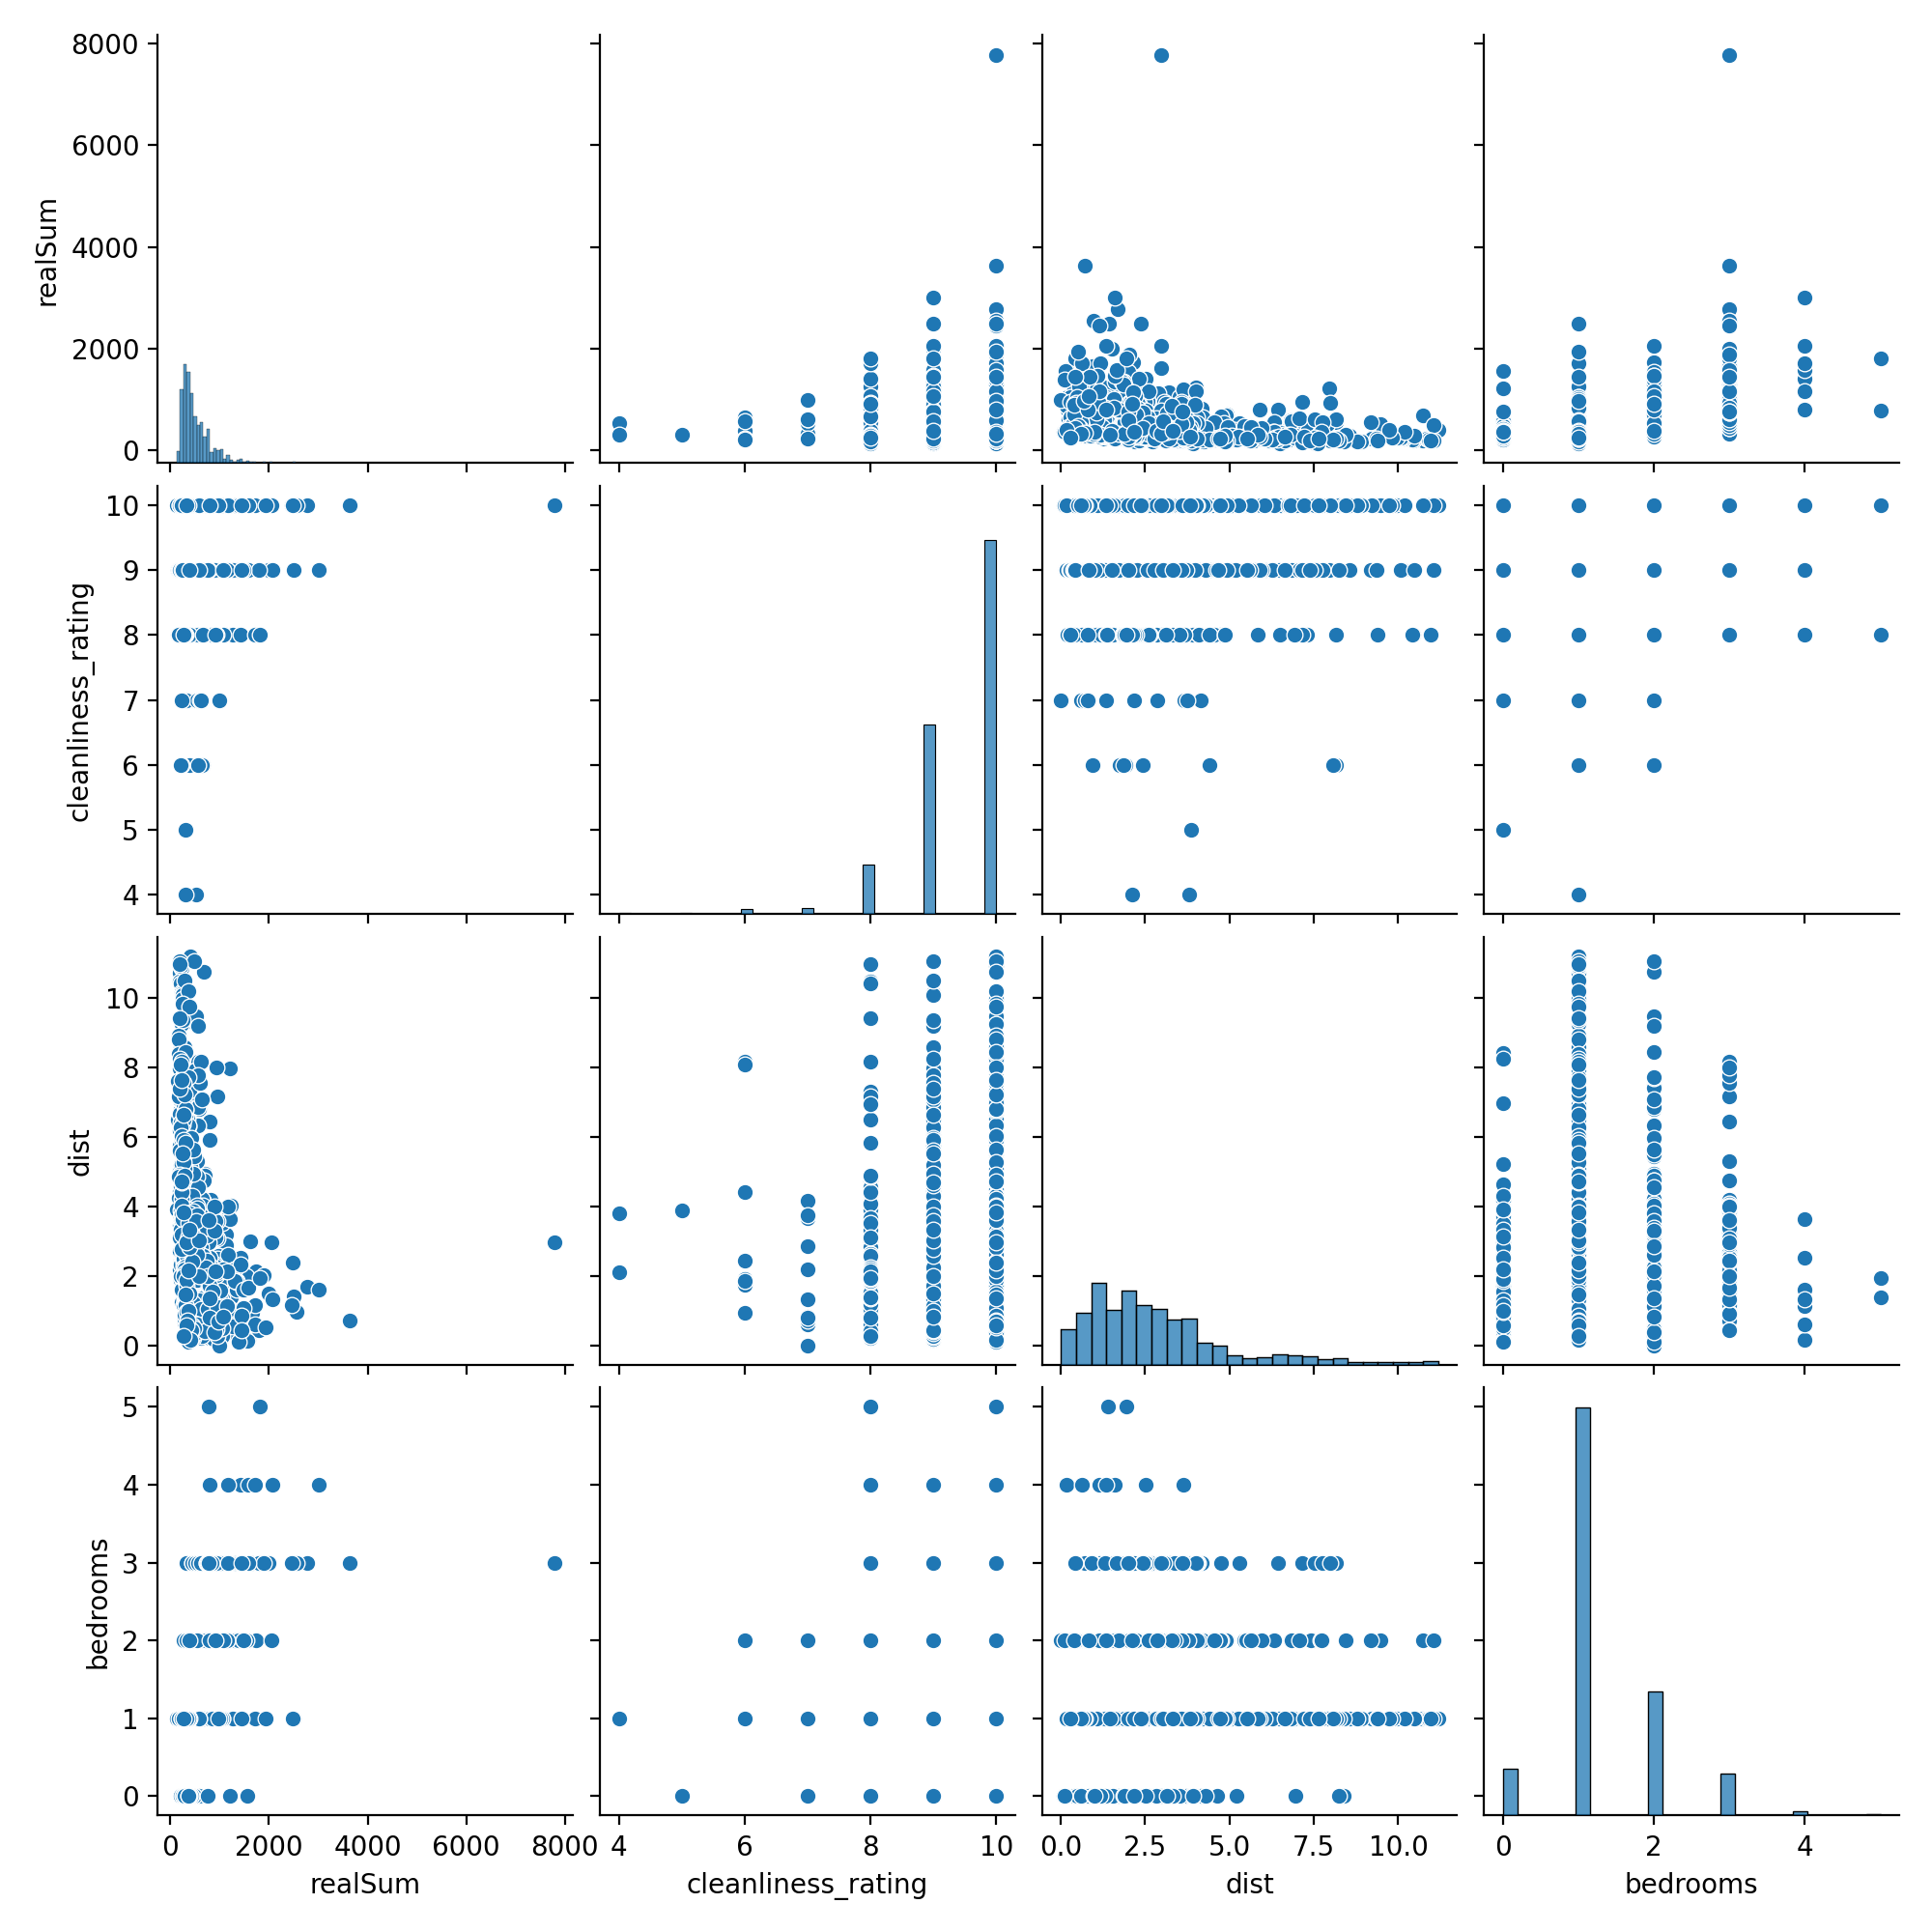

In [24]:
import seaborn as sns
sns.pairplot(amsterdam_weekdays, vars=['realSum', 'cleanliness_rating', 'dist', 'bedrooms'])
plt.show()

C:\Users\rahelpet\AppData\Local\Temp\ipykernel_2172\2055482116.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


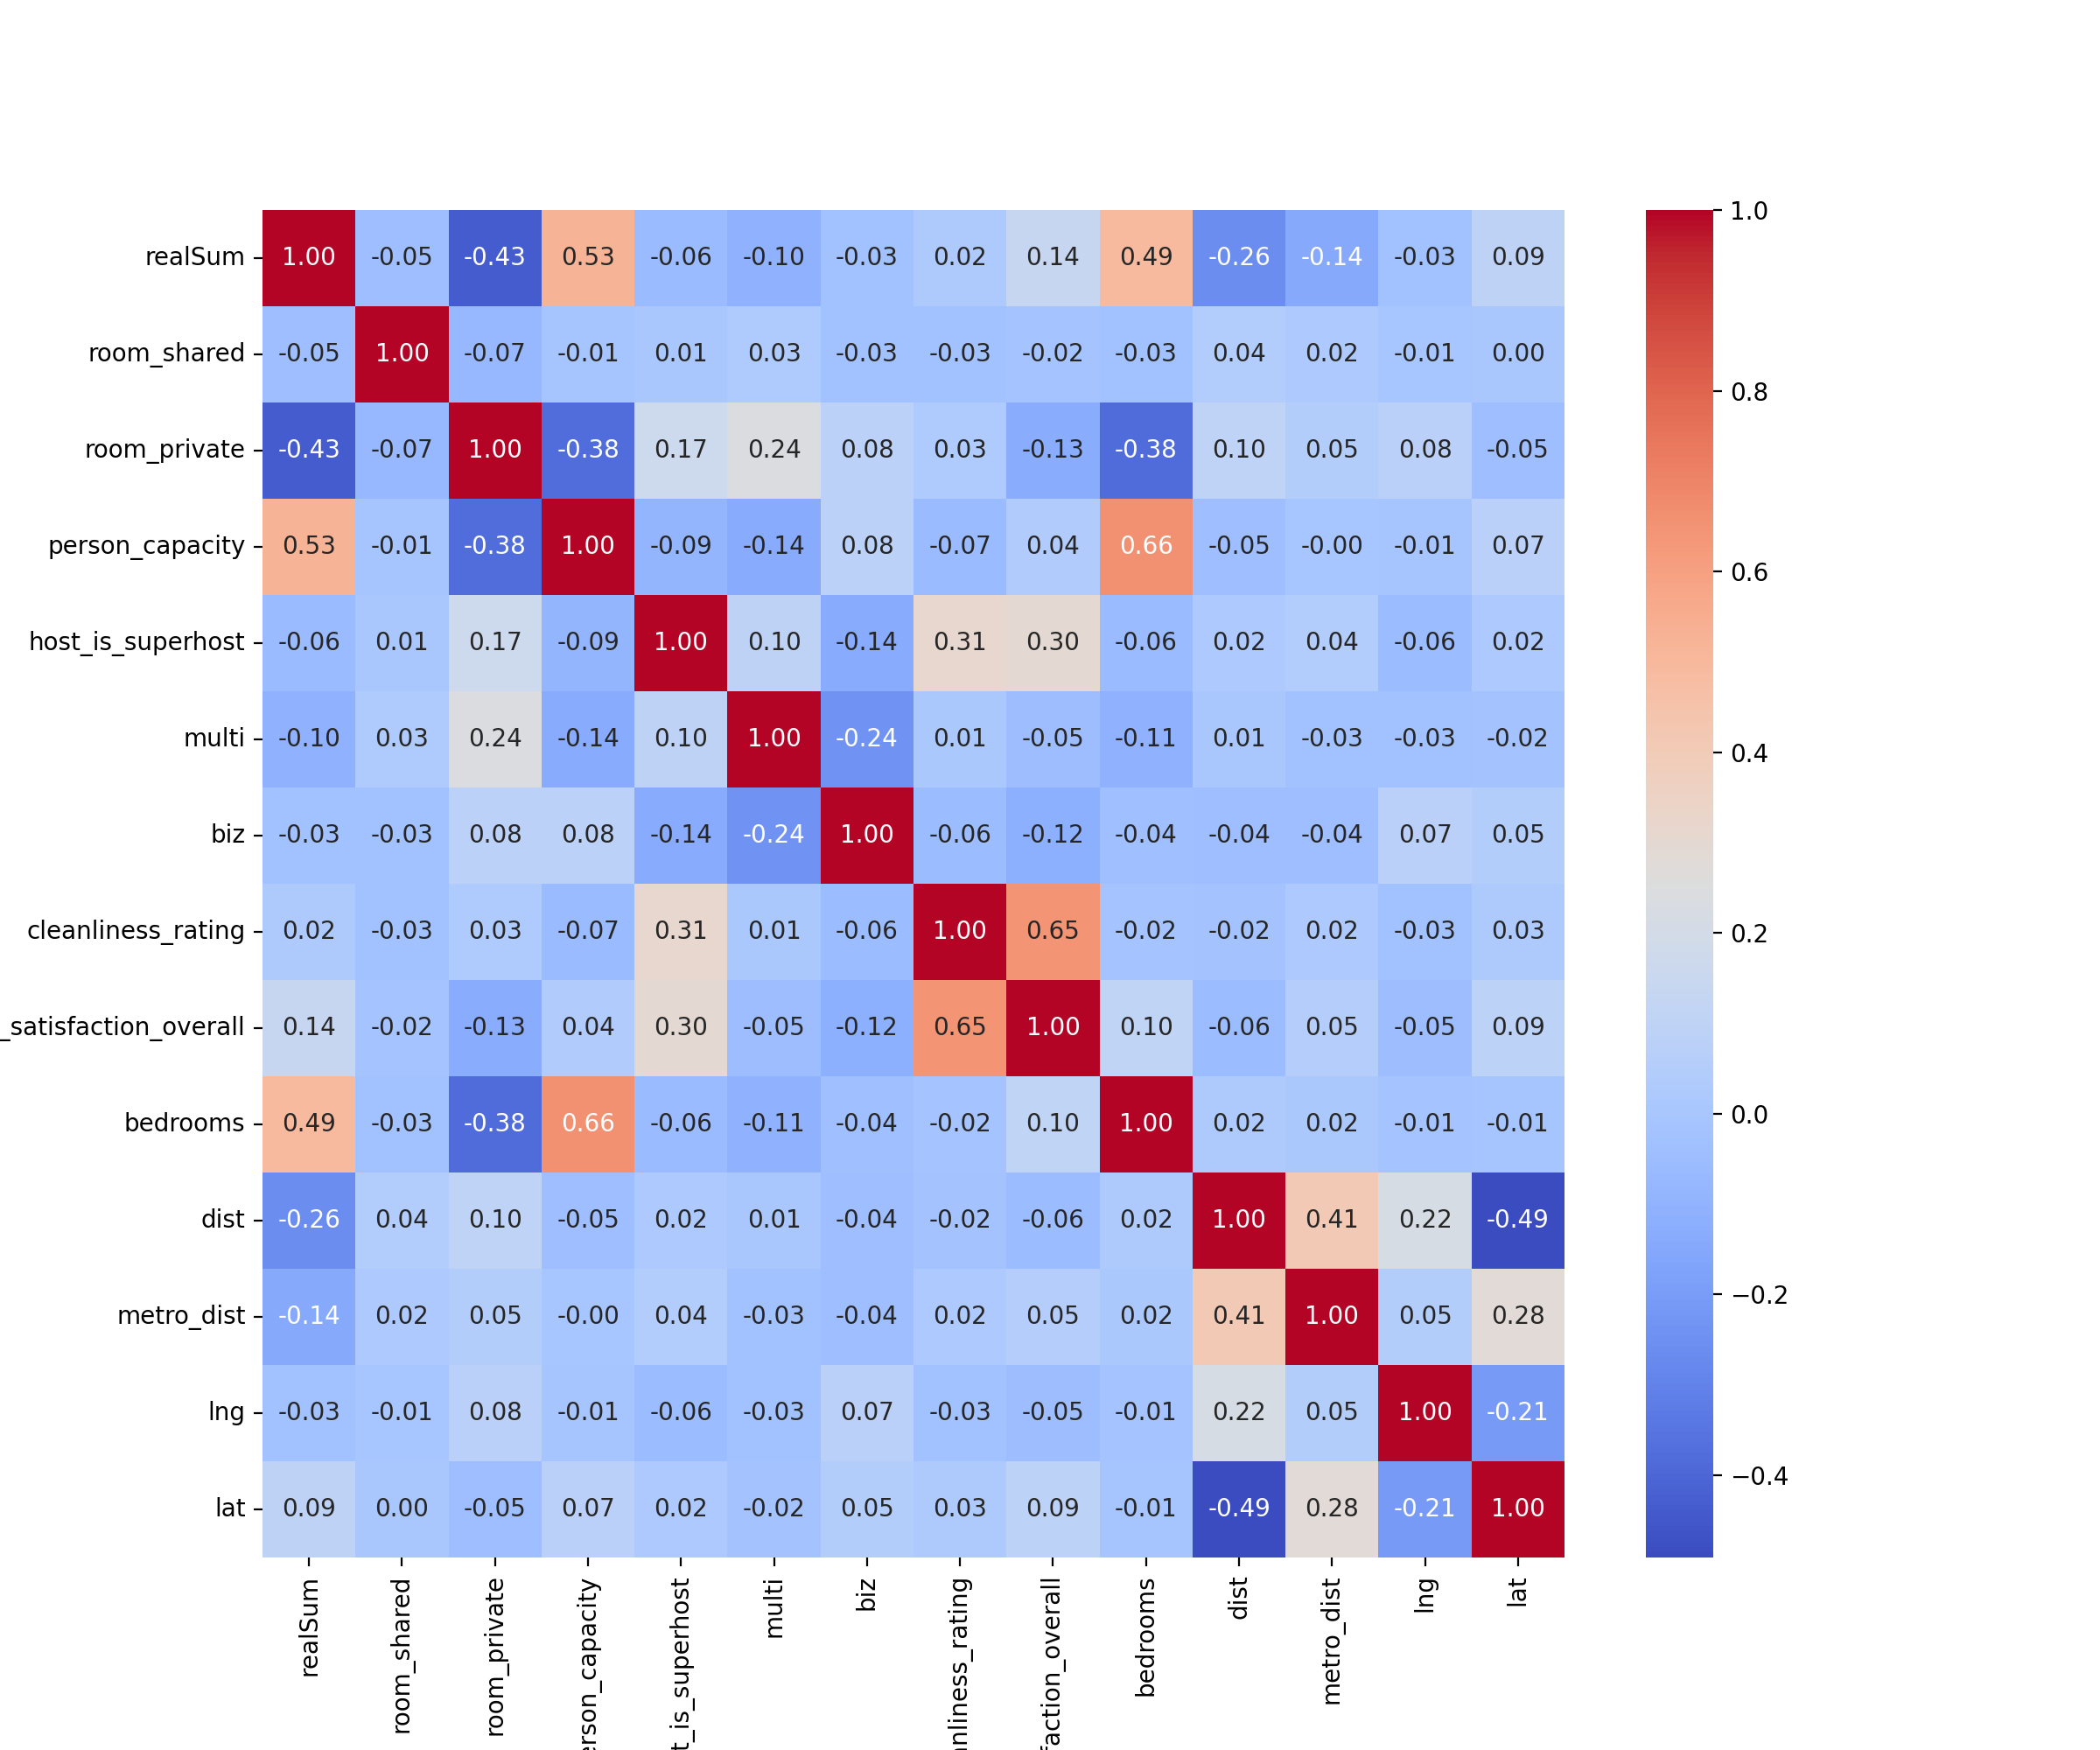

In [51]:
plt.figure(figsize=(12, 10))

correlation_matrix = amsterdam_weekdays.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()


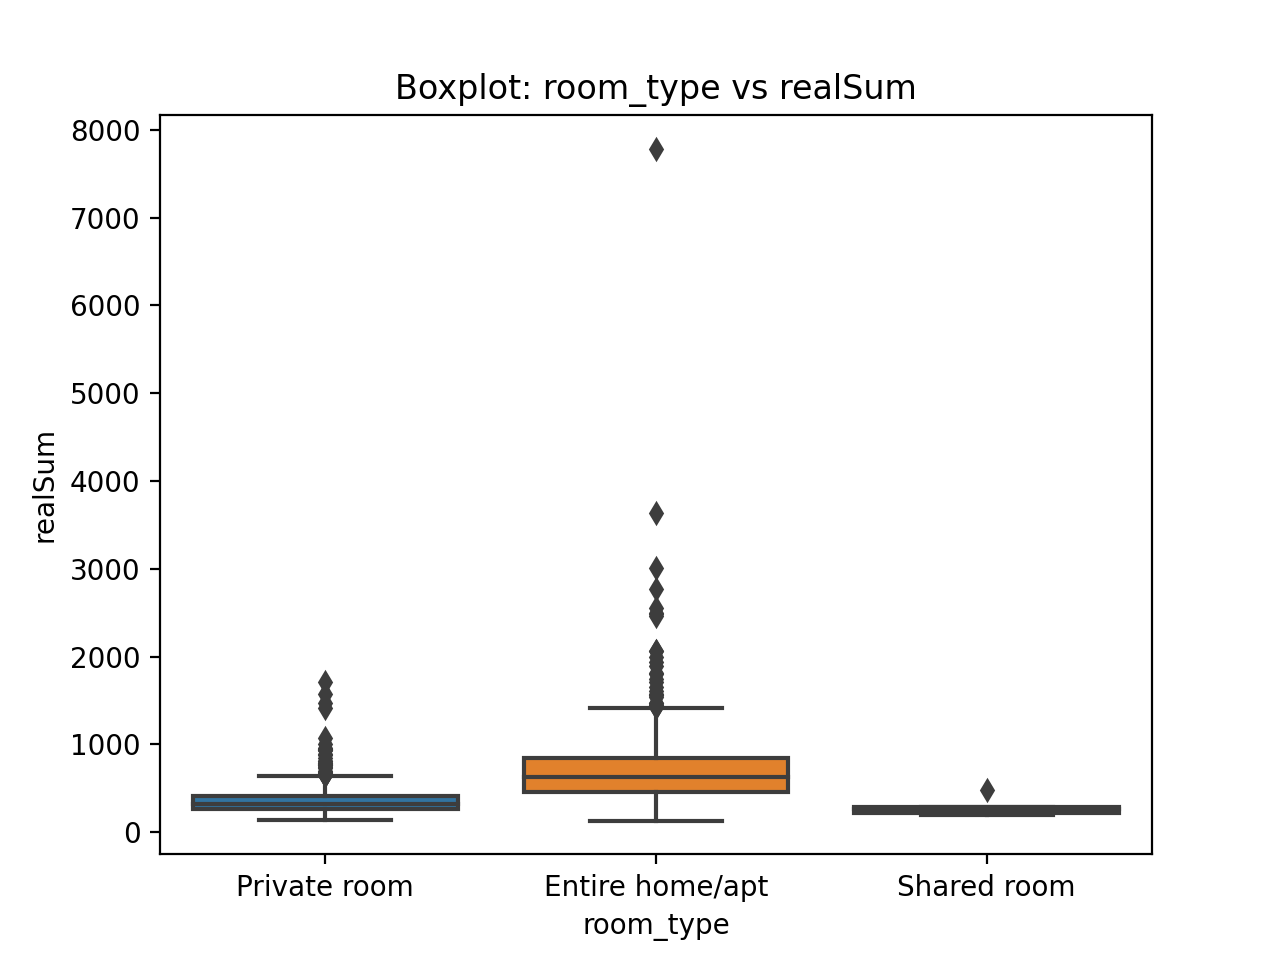

In [52]:
sns.boxplot(x='room_type', y='realSum', data=amsterdam_weekdays)
plt.title('Boxplot: room_type vs realSum')
plt.show()